<a href="https://colab.research.google.com/github/georgeliu1998/keras_model_tuning/blob/master/keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from numpy.random import seed
seed(6)

from tensorflow import set_random_seed
set_random_seed(6)

import numpy as np
seed = np.random.RandomState(6)

In [0]:
import pandas as pd
import sklearn
import pickle
from time import time
import importlib 
from copy import deepcopy

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, Normalizer

import xgboost as xgb


from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
#from keras.wrappers.scikit_learn import KerasClassifier

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
# Mount gdrive 
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [50]:
pima = pd.read_csv("/content/gdrive/My Drive/pima-indians-diabetes.csv", header=None)
print(pima.head())

# Get the features and labels as np arrays
X, y = pima.values[:, 0:8], pima.values[:, 8]
print(pima.shape, pima.shape)

   0    1   2   3    4     5      6   7  8
0  6  148  72  35    0  33.6  0.627  50  1
1  1   85  66  29    0  26.6  0.351  31  0
2  8  183  64   0    0  23.3  0.672  32  1
3  1   89  66  23   94  28.1  0.167  21  0
4  0  137  40  35  168  43.1  2.288  33  1
(768, 9) (768, 9)


In [51]:
# Check percentage of both classes
pima[8].value_counts()/pima.shape[0]

0    0.651042
1    0.348958
Name: 8, dtype: float64

In [52]:
# Get baseline accuracy using XGBoost
t1 = time()
clf = xgb.XGBClassifier()
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
scores = cross_val_score(clf, X, y, cv=cv)
t2 = time()
t = t2 - t1

print("Mean Accuracy: {:.2%}, Standard Deviation: {:.2%}".format(scores.mean(), scores.std()))
print("Time taken: {:.2f} seconds".format(t))

Mean Accuracy: 75.91%, Standard Deviation: 3.62%
Time taken: 0.41 seconds


In [53]:
# Let's test with data standardization:
std_scaler = StandardScaler()
X_std = std_scaler.fit_transform(X)

scores = cross_val_score(clf, X_std, y, cv=cv)

print("Mean Accuracy: {:.2%}, Standard Deviation: {:.2%}".format(scores.mean(), scores.std()))

Mean Accuracy: 76.43%, Standard Deviation: 2.19%


In [0]:
class SequentialModel:
  """
  The base class for a Neural Networks model
  """
  
  def __init__(self, input_dim, num_layers, num_units, 
               activation, activation_out, 
               loss, initializer, optimizer, learning_rate, 
               epochs, batch_size, metrics=['accuracy'], one_hot=False):
    """
    Params:
      input_dim: int, number of features
      num_layers: int, number of layers of the model (excluding the input layer)
      num_units: list, number of units in each layer(excluding the input layer)
      activation: str, activation function used in all layers except output
      activation_out: str, activation function used in output layer
      loss: str, loss functon
      initializer: str, kernel initializer
      optimizer: str, optimizer
      metrics: list of strings, metrics used
      epochs: int, number of epochs to train for
      batch_size: int, number of samples per batch
      one_hot: bool, whether one hot encoding is needed
    """
    self.input_dim = input_dim
    self.num_layers = num_layers
    self.num_units = [num_units, 1]
    self.activation = activation
    self.activation_out = activation_out
    self.loss = loss
    self.initializer = initializer
    self.optimizer = optimizer
    self.learning_rate = learning_rate
    self.metrics = metrics
    self.epochs = epochs
    self.batch_size = batch_size
    self.one_hot = one_hot
    
    # Initialize the sequential model
    self.model = Sequential()

    
  def build_model(self):
    """
    Adds layers and compiles the model
    """
    # Ensure num_units tuple's length is the same as num_layers
    if self.num_layers != len(self.num_units):
      # Expand the list by repeating number of nodes except for last layer
      num_nodes, num_nodes_out = self.num_units[0], self.num_units[-1]
      self.num_units = [i for i in range(self.num_layers-1) for i in [num_nodes]]
      self.num_units.append(num_nodes_out) 
 
    # Loop thru all the layers
    for i in range(self.num_layers):
      # different layers should have different setups
      if i == 0: # input and first hidden layer
        self.model.add(Dense(units=self.num_units[i],
                             input_dim=self.input_dim,
                             kernel_initializer=self.initializer,
                             activation=self.activation)) 
      elif i+1 == self.num_layers: # output layer
        self.model.add(Dense(units=self.num_units[i],
                             kernel_initializer=self.initializer,
                             activation=self.activation_out))
      else: # hidden layers
        self.model.add(Dense(units=self.num_units[i],
                            kernel_initializer=self.initializer,
                            activation=self.activation))
    
    # Instantiate the optimizer class
    optimizer_class = getattr(importlib.import_module("keras.optimizers"), 
                             self.optimizer)
    self.optimizer = optimizer_class(lr=self.learning_rate)
    # Compile the model
    self.model.compile(loss=self.loss,
                       optimizer=self.optimizer,
                       metrics=self.metrics)
        
  
  def evaluate_model(self, X, y, n_splits=10):
    """
    Evaluates the model using cross-validation.
    
    Params:
      X: np.array, features
      y: np.array, labels
      n_splits: int, number of folds for the cross-validation
    Returns:
      mean_accuracy: float, the average accuracy based on the cross-validation.
    
    """
    score_lst = []
    t1 = time()
    
    print("Starting {}-fold cross-validation...".format(n_splits))
    
    kfold = StratifiedKFold(n_splits=n_splits, 
                            shuffle=True, 
                            random_state=seed)
    
    # Loop through the different folds
    for train_index, test_index in kfold.split(X, y):
      # Do one-hot encoding when needed
      if self.one_hot:
        y_one_hot = to_categorical(y)
      else:
        y_one_hot = y
        
      self.model.fit(X[train_index],
                     y_one_hot[train_index],
                     epochs=self.epochs,
                     batch_size=self.batch_size,
                     verbose=0)
        
      scores = self.model.evaluate(X[test_index],
                                   y_one_hot[test_index], 
                                   verbose=0)
            
      # The second item is accuracy
      score_lst.append(scores[1])

    t2 = time()
    t = t2 - t1
    # Convert time to mintues
    t /= 60

    print("Finished cross-valiation. Took {:.1f} mintues.".format(t))

    # Convert to np.array and calculate mean and sd
    score_lst = np.array(score_lst)
    mean_acc = score_lst.mean()
    sd_acc = score_lst.std()

    print("Mean Accuracy: {:.2%}, Standard Deviation: {:.2%}".format(mean_acc, sd_acc))
    return mean_acc

In [0]:
def get_defaults(input_dim=8, 
                 num_layers=2,
                 num_units=8,
                 activation='relu',
                 activation_out='sigmoid',
                 loss='binary_crossentropy',
                 initializer='random_uniform',
                 optimizer='adam',
                 learning_rate=0.001,
                 metrics=['accuracy'],
                 epochs=10, 
                 batch_size=4,
                 one_hot=False):
  """
  Returns a dict of default hyperparameter values
  """

  defaults = {'input_dim': input_dim, 
              'num_layers': num_layers, 
              'num_units': num_units, 
              'activation': activation, 
              'activation_out': activation_out, 
              'loss': loss, 
              'initializer': initializer, 
              'optimizer': optimizer, 
              'learning_rate': learning_rate, 
              'metrics': metrics, 
              'epochs': epochs, 
              'batch_size': batch_size, 
              'one_hot': one_hot}
  
  return defaults


def get_tuning_options(**kwargs):
  """
  Define tuning parameter and corresponding options
  
  Params:
    -----------------####################
  Returns:
    -----------------####################
  
  """ 
  tuning_options = {}
  
  for param, options in kwargs.items():
    tuning_options[param] = options 
  
  return tuning_options

In [0]:
def build_eval(X, y, param_dict):
  """
  Builds a Neural Network model using the given params and returns the 
  cross-validation accuracy
  
  Params:
    param_dict: dict - Python dict containing the tuning parameters and values
  
  Returns:
    result: float - percentage accuracy based on cross-validation
  """
  print("Building model using param_dict:\n {}".format(param_dict))
  model = SequentialModel(input_dim=param_dict['input_dim'], 
                          num_layers=param_dict['num_layers'], 
                          num_units=param_dict['num_units'],
                          activation=param_dict['activation'], 
                          activation_out=param_dict['activation_out'], 
                          loss=param_dict['loss'], 
                          initializer=param_dict['initializer'], 
                          optimizer=param_dict['optimizer'], 
                          learning_rate=param_dict['learning_rate'],
                          epochs=param_dict['epochs'], 
                          batch_size=param_dict['batch_size'])
  model.build_model()
  result = model.evaluate_model(X, y)
  
  return result


def run_test(X, y, param_dict, tuning_options=None):
  """
  Tests different parameter's accurcy using the given tuning options

  Params:
    -----------------####################
  Returns:
    -----------------####################

  """
  if tuning_options:
    results = {}
        
    for parameter, options in  tuning_options.items():
      results[parameter] = {}
      param_dict_temp = deepcopy(param_dict)
      
      for option in options:
        print("\nEvaluating parameter \"{}\" using value \"{}\"...".format(parameter, option))
        # Update the corresponding parameter
        param_dict_temp[parameter] = option
        
        try:
          #print("param_dict_temp: {}".format(param_dict_temp))
          results[parameter][option] = build_eval(X, y, param_dict_temp)
        except Exception as e: 
          results[parameter][option] = 'NaN'
          print('Error: {}, skipping...'.format(e))
          pass
    return results
  
  else:
    return build_eval(X, y, param_dict)

In [0]:
def wrangle_results(results):
    """
    
    Params:
      results: dict - the results dict returned by the build_eval() function

    Returns:
        df_plot: pandas df, the wrangled long format dataframe
    """
    df = pd.DataFrame(results)
    # Get the col names as value vars for melt func
    value_vars = df.columns.tolist()
    # Reset index and rename the index col 
    df = df.reset_index().rename(columns={'index': 'option'})
    # Transform from wide to long format for easy plotting
    df_long = pd.melt(df, id_vars='option', value_vars=value_vars)
    df_long = df_long.rename(columns={'variable': 'parameter'})
    # Exclude the zero and null values
    df_long = df_long[~df_long['value'].isnull()]
    df_long = df_long.query("value!=0 & value!='NaN'")

    # Calculate the range and sd of each parameter group and convert to a df
    ranges = df_long.groupby('parameter').apply(lambda grp: grp.value.max() - grp.value.min())
    sd = df_long.groupby('parameter').apply(lambda grp: grp.value.std())
    spread = pd.concat([ranges, sd], axis=1).rename(columns={0: 'ranges', 1: 'sd'})
    # Join back the df
    df_spread = pd.merge(df_long, spread, how='left', left_on='parameter', right_index=True)
    # Reorder columns
    df_spread = df_spread[['parameter', 'option', 'value', 'ranges', 'sd']]
    # Remove the row with zero value
    df_spread = df_spread.query('ranges!=0')
    # Change column dtype
    df_spread['value'] = df_spread['value'].astype(float)
    # Sort the dataframe and use the resulting index to slice
    # This ensures the plot will be ordered accordingly
    idx = df_spread.sort_values(by=['ranges', 'option'], ascending=False).index
    df_plot = df_spread.loc[idx, :]
    
    return df_plot

  
def get_best_options(df):
  #df =  df.query("parameter==@param")
  best_options = df.groupby('parameter').apply(lambda grp: grp.nlargest(1, 'value'))[['parameter', 'option']].values.tolist()
  
  return best_options  


def visualize_distribution(df, save_figure=False):
  fig, ax = plt.subplots(figsize=(16, 12))
  df['value'] =  df['value'].astype(float)
  sns.boxplot(x='parameter', y='value', data=df, ax=ax)
  sns.swarmplot(x='parameter', y='value', data=df, size=12, ax=ax)
  ax.set_xlabel('Parameters',size=16)
  ax.set_ylabel('Values',size=16)
  fig_title = 'Parameter Tuning Results Distribution'
  ax.set_title(fig_title, y=1.05, fontsize=30)
  
  if save_figure:
    figure_name = '/content/gdrive/My Drive/' + fig_title + '.png'
    fig.savefig(figure_name)


def visualize_trend(df, save_figure=False):
  fig, axes = plt.subplots(nrows=2, ncols=4, sharey=True, figsize=(30, 12))
  axes = axes.flatten()
  # Get the parameter list
  params = df.parameter.unique().tolist()
  # Loop thru the axes
  for i, ax in enumerate(axes):
    try:
      # Each subplot corresponds to one parameter
      param = params[i]
      df_param = df.query("parameter==@param")
      df_param.plot(kind='line', x='option', y='value', ax=ax)
      # Log-transform the x-axis for learning rate to avoid mixing up
      if param == 'learning_rate':
        ax.set_xscale('log')
      # Set the x ticks and tick lables
      if param in ('initializer', 'optimizer'):
        ax.set_xticks(np.arange(5))
        ax.set_xticklabels(df_param.option)
      ax.set_xlabel(param, fontsize=16) 
      ax.set_ylabel('Accuracy', fontsize=16) 
      ax.get_legend().remove()
    except:
      # Remove the last axis since we have only 7 params
      fig.delaxes(ax)
  
  fig_title = 'Parameter Tuning Trend'
  fig.suptitle(fig_title, y=0.92, verticalalignment='bottom', fontsize=30)
  
  plt.show()
  
  if save_figure:
    figure_name = '/content/gdrive/My Drive/' + fig_title + '.png'
    fig.savefig(figure_name)


In [0]:
param_dict = get_defaults()

num_units = [4, 8, 16, 32, 64]
num_layers = [2, 4, 8, 16, 32]
loss = ['binary_crossentropy', 'categorical_crossentropy', 'sparse_categorical_crossentropy']
initializer = ['random_uniform', 'random_normal', 'TruncatedNormal', 'glorot_normal', 'glorot_uniform']
learning_rate = [0.001, 0.002, 0.01, 0.1, 1]
optimizer = ['adam', 'adamax', 'adagrad', 'sgd', 'rmsprop']
epochs = [10, 20, 40, 80, 160]
batch_size = [1, 2, 4, 8, 16]


tuning_options = get_tuning_options(num_units=num_units, 
                                    num_layers=num_layers, 
                                    loss=loss, 
                                    initializer=initializer,
                                    learning_rate=learning_rate, 
                                    optimizer=optimizer, 
                                    epochs=epochs, 
                                    batch_size=batch_size)

In [46]:
# Get baseline accuracy using defauls with the defined Neural Networks class  

run_test(X=X, y=y, param_dict=param_dict)

Building model using param_dict:
 {'input_dim': 8, 'num_layers': 2, 'num_units': 8, 'activation': 'relu', 'activation_out': 'sigmoid', 'loss': 'binary_crossentropy', 'initializer': 'random_uniform', 'optimizer': 'adam', 'learning_rate': 0.001, 'metrics': ['accuracy'], 'epochs': 10, 'batch_size': 4, 'one_hot': False}
Starting 10-fold cross-validation...
Finished cross-valiation. Took 1.5 mintues.
Mean Accuracy: 74.86%, Standard Deviation: 4.59%


0.7485645950818339

In [13]:
# Test all the tuning options
results = run_test(X=X, y=y, param_dict=param_dict,
                   tuning_options=tuning_options)

# Save the tuning results 
with open('/content/gdrive/My Drive/cross_validation_results.pkl', 'wb') as f:
    pickle.dump(results, f, pickle.HIGHEST_PROTOCOL)
    print("\nResults saved to Google Drive successfully!")


Evaluating parameter "num_units" using value "4"...
Building model using param_dict:
 {'input_dim': 8, 'num_layers': 2, 'num_units': 4, 'activation': 'relu', 'activation_out': 'sigmoid', 'loss': 'binary_crossentropy', 'initializer': 'random_uniform', 'optimizer': 'adam', 'learning_rate': 0.001, 'metrics': ['accuracy'], 'epochs': 10, 'batch_size': 4, 'one_hot': False}
Starting 10-fold cross-validation...
Finished cross-valiation. Took 1.2 mintues.
Mean Accuracy: 73.06%, Standard Deviation: 3.67%

Evaluating parameter "num_units" using value "8"...
Building model using param_dict:
 {'input_dim': 8, 'num_layers': 2, 'num_units': 8, 'activation': 'relu', 'activation_out': 'sigmoid', 'loss': 'binary_crossentropy', 'initializer': 'random_uniform', 'optimizer': 'adam', 'learning_rate': 0.001, 'metrics': ['accuracy'], 'epochs': 10, 'batch_size': 4, 'one_hot': False}
Starting 10-fold cross-validation...
Finished cross-valiation. Took 1.3 mintues.
Mean Accuracy: 72.28%, Standard Deviation: 4.17

In [15]:
# Load the pickled results dict
with open('/content/gdrive/My Drive/cross_validation_results.pkl', 'rb') as f:
    results = pickle.load(f)

df = wrangle_results(results)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


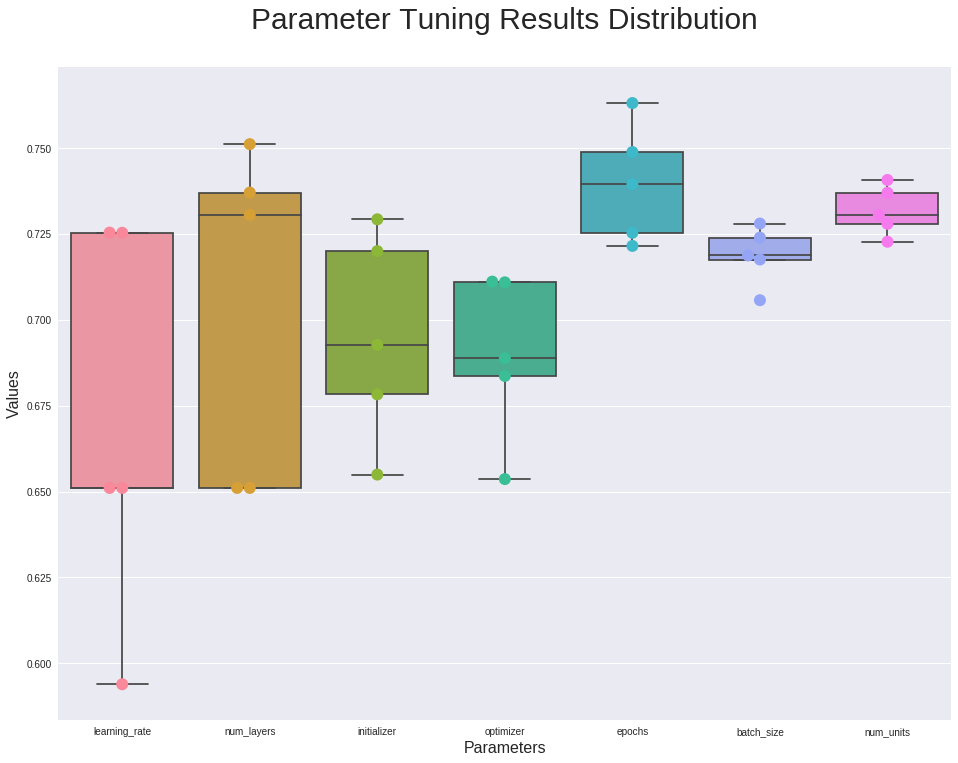

In [16]:
visualize_distribution(df)

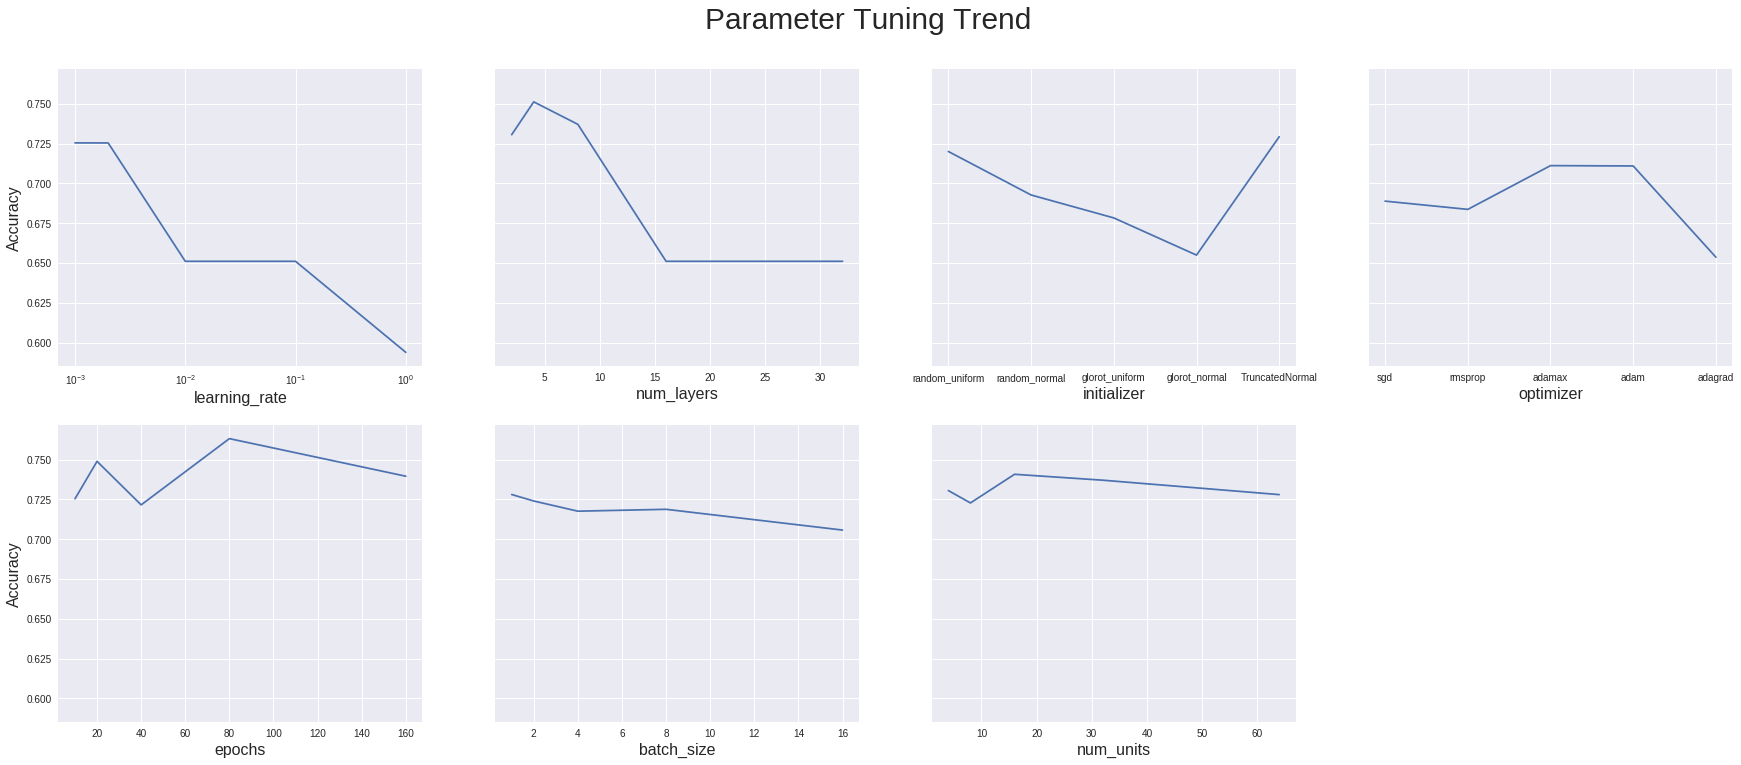

In [17]:
visualize_trend(df)

In [18]:
best_options = get_best_options(df)
print(best_options)

for i in best_options:
  param_dict[i[0]] = i[1]
print(param_dict)

[['batch_size', 1], ['epochs', 80], ['initializer', 'TruncatedNormal'], ['learning_rate', 0.001], ['num_layers', 4], ['num_units', 16], ['optimizer', 'adamax']]
{'input_dim': 8, 'num_layers': 4, 'num_units': 16, 'activation': 'relu', 'activation_out': 'sigmoid', 'loss': 'binary_crossentropy', 'initializer': 'TruncatedNormal', 'optimizer': 'adamax', 'learning_rate': 0.001, 'metrics': ['accuracy'], 'epochs': 80, 'batch_size': 1, 'one_hot': False}


In [19]:
# Build a model using the best options
run_test(X=X, y=y, param_dict=param_dict)

Building model using param_dict:
 {'input_dim': 8, 'num_layers': 4, 'num_units': 16, 'activation': 'relu', 'activation_out': 'sigmoid', 'loss': 'binary_crossentropy', 'initializer': 'TruncatedNormal', 'optimizer': 'adamax', 'learning_rate': 0.001, 'metrics': ['accuracy'], 'epochs': 80, 'batch_size': 1, 'one_hot': False}
Starting 10-fold cross-validation...
Finished cross-valiation. Took 50.1 mintues.
Mean Accuracy: 78.13%, Standard Deviation: 4.50%


0.7813055378805671

Wow, that's brutal - it took 50 minutes! But I guess I cannot complain since the result is great! Definitely close to top results for this dataset. Let's now try tuning individual parameters using the default parameter settings.



In [20]:
param_dict = get_defaults()
# Get 6 randomly generated learning rates
bases = np.repeat(10, 6)
exponents = -(np.random.rand(6) + 2) # the exponent should be between -2 and -3
learning_rate = np.power(bases, exponents).tolist() 

tuning_options = get_tuning_options(learning_rate=learning_rate)

results = run_test(X=X, y=y, 
                   param_dict=param_dict, 
                   tuning_options=tuning_options)


Evaluating parameter "learning_rate" using value "0.0011589780553470678"...
Building model using param_dict:
 {'input_dim': 8, 'num_layers': 2, 'num_units': 8, 'activation': 'relu', 'activation_out': 'sigmoid', 'loss': 'binary_crossentropy', 'initializer': 'random_uniform', 'optimizer': 'adam', 'learning_rate': 0.0011589780553470678, 'metrics': ['accuracy'], 'epochs': 10, 'batch_size': 4, 'one_hot': False}
Starting 10-fold cross-validation...
Finished cross-valiation. Took 1.4 mintues.
Mean Accuracy: 73.83%, Standard Deviation: 5.48%

Evaluating parameter "learning_rate" using value "0.0014018907004056484"...
Building model using param_dict:
 {'input_dim': 8, 'num_layers': 2, 'num_units': 8, 'activation': 'relu', 'activation_out': 'sigmoid', 'loss': 'binary_crossentropy', 'initializer': 'random_uniform', 'optimizer': 'adam', 'learning_rate': 0.0014018907004056484, 'metrics': ['accuracy'], 'epochs': 10, 'batch_size': 4, 'one_hot': False}
Starting 10-fold cross-validation...
Finished cr

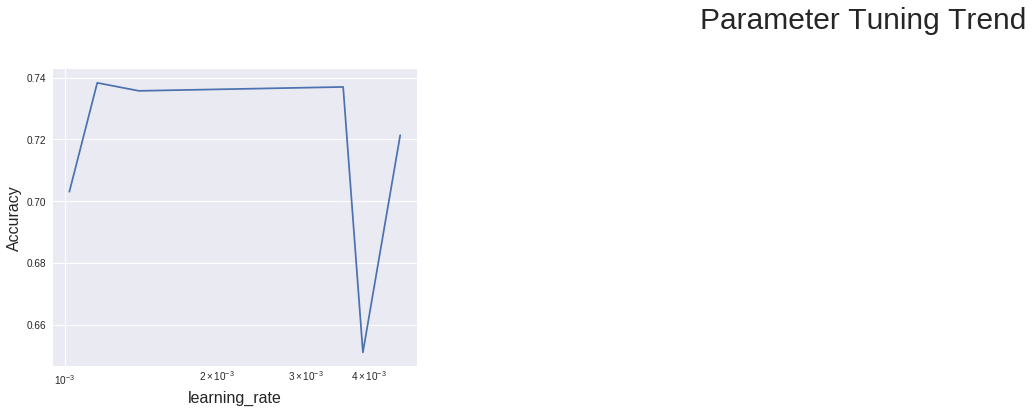

In [21]:
df = wrangle_results(results)
visualize_trend(df)

In [22]:
best_lr = get_best_options(df)
best_lr

[['learning_rate', 0.0011589780553470678]]

In [23]:
param_dict['learning_rate'] = best_lr[0][1]

run_test(X=X, y=y, param_dict=param_dict)

Building model using param_dict:
 {'input_dim': 8, 'num_layers': 2, 'num_units': 8, 'activation': 'relu', 'activation_out': 'sigmoid', 'loss': 'binary_crossentropy', 'initializer': 'random_uniform', 'optimizer': 'adam', 'learning_rate': 0.0011589780553470678, 'metrics': ['accuracy'], 'epochs': 10, 'batch_size': 4, 'one_hot': False}
Starting 10-fold cross-validation...
Finished cross-valiation. Took 1.5 mintues.
Mean Accuracy: 72.39%, Standard Deviation: 4.13%


0.7238550943274736

Let's check the baseline model and confirm the model above is indeed better:

In [24]:
param_dict_defaults = get_defaults()
run_test(X=X, y=y, param_dict=param_dict_defaults)

Building model using param_dict:
 {'input_dim': 8, 'num_layers': 2, 'num_units': 8, 'activation': 'relu', 'activation_out': 'sigmoid', 'loss': 'binary_crossentropy', 'initializer': 'random_uniform', 'optimizer': 'adam', 'learning_rate': 0.001, 'metrics': ['accuracy'], 'epochs': 10, 'batch_size': 4, 'one_hot': False}
Starting 10-fold cross-validation...
Finished cross-valiation. Took 1.5 mintues.
Mean Accuracy: 72.92%, Standard Deviation: 4.35%


0.7292036930584207

This is weird since the model with tuned parameter has a even lower accuracy. A possible reason is randomness that is resulted from libraries other than Numpy, TensorFlow and Keras, the result is just an outlier. Nevertheless, let's keep the learning rate.

Next, let's keep the updated learning rate and tune batch size:

In [28]:
batch_size = [2 ** e for e in range(3)]

tuning_options = get_tuning_options(batch_size=batch_size)

results = run_test(X=X, y=y, 
                   param_dict=param_dict, 
                   tuning_options=tuning_options)


Evaluating parameter "batch_size" using value "1"...
Building model using param_dict:
 {'input_dim': 8, 'num_layers': 2, 'num_units': 8, 'activation': 'relu', 'activation_out': 'sigmoid', 'loss': 'binary_crossentropy', 'initializer': 'random_uniform', 'optimizer': 'adam', 'learning_rate': 0.0011589780553470678, 'metrics': ['accuracy'], 'epochs': 10, 'batch_size': 1, 'one_hot': False}
Starting 10-fold cross-validation...
Finished cross-valiation. Took 5.7 mintues.
Mean Accuracy: 69.15%, Standard Deviation: 5.17%

Evaluating parameter "batch_size" using value "2"...
Building model using param_dict:
 {'input_dim': 8, 'num_layers': 2, 'num_units': 8, 'activation': 'relu', 'activation_out': 'sigmoid', 'loss': 'binary_crossentropy', 'initializer': 'random_uniform', 'optimizer': 'adam', 'learning_rate': 0.0011589780553470678, 'metrics': ['accuracy'], 'epochs': 10, 'batch_size': 2, 'one_hot': False}
Starting 10-fold cross-validation...
Finished cross-valiation. Took 3.0 mintues.
Mean Accuracy

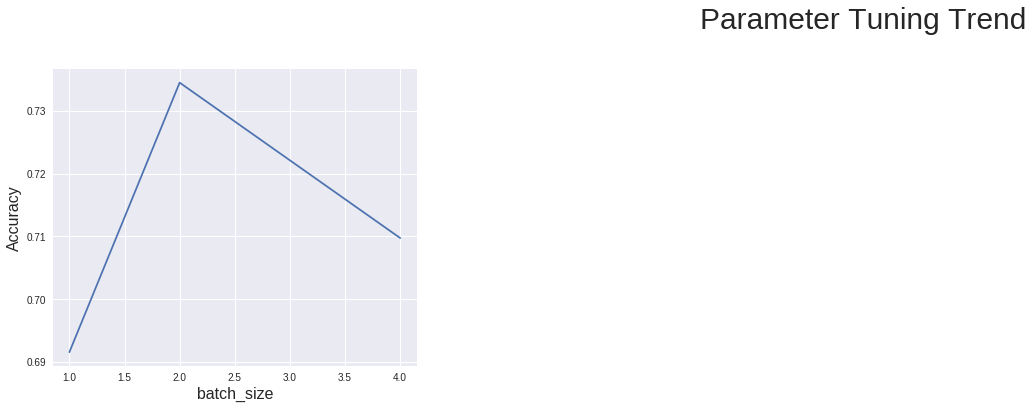

In [29]:
df = wrangle_results(results)
visualize_trend(df)

So let's change batch_size to 2 and train again.

In [33]:
best_batch_size = get_best_options(df)
param_dict['batch_size'] = best_batch_size[0][1]

run_test(X=X, y=y, param_dict=param_dict)

Building model using param_dict:
 {'input_dim': 8, 'num_layers': 2, 'num_units': 8, 'activation': 'relu', 'activation_out': 'sigmoid', 'loss': 'binary_crossentropy', 'initializer': 'random_uniform', 'optimizer': 'adam', 'learning_rate': 0.0011589780553470678, 'metrics': ['accuracy'], 'epochs': 10, 'batch_size': 2, 'one_hot': False}
Starting 10-fold cross-validation...
Finished cross-valiation. Took 3.0 mintues.
Mean Accuracy: 74.09%, Standard Deviation: 4.26%


0.740943269503907

That's perfect. Now, let's keep this batch size and test different epoch options:


Evaluating parameter "epochs" using value "20"...
Building model using param_dict:
 {'input_dim': 8, 'num_layers': 2, 'num_units': 8, 'activation': 'relu', 'activation_out': 'sigmoid', 'loss': 'binary_crossentropy', 'initializer': 'random_uniform', 'optimizer': 'adam', 'learning_rate': 0.0011589780553470678, 'metrics': ['accuracy'], 'epochs': 20, 'batch_size': 2, 'one_hot': False}
Starting 10-fold cross-validation...
Finished cross-valiation. Took 5.9 mintues.
Mean Accuracy: 76.04%, Standard Deviation: 4.66%

Evaluating parameter "epochs" using value "60"...
Building model using param_dict:
 {'input_dim': 8, 'num_layers': 2, 'num_units': 8, 'activation': 'relu', 'activation_out': 'sigmoid', 'loss': 'binary_crossentropy', 'initializer': 'random_uniform', 'optimizer': 'adam', 'learning_rate': 0.0011589780553470678, 'metrics': ['accuracy'], 'epochs': 60, 'batch_size': 2, 'one_hot': False}
Starting 10-fold cross-validation...
Finished cross-valiation. Took 17.7 mintues.
Mean Accuracy: 75.

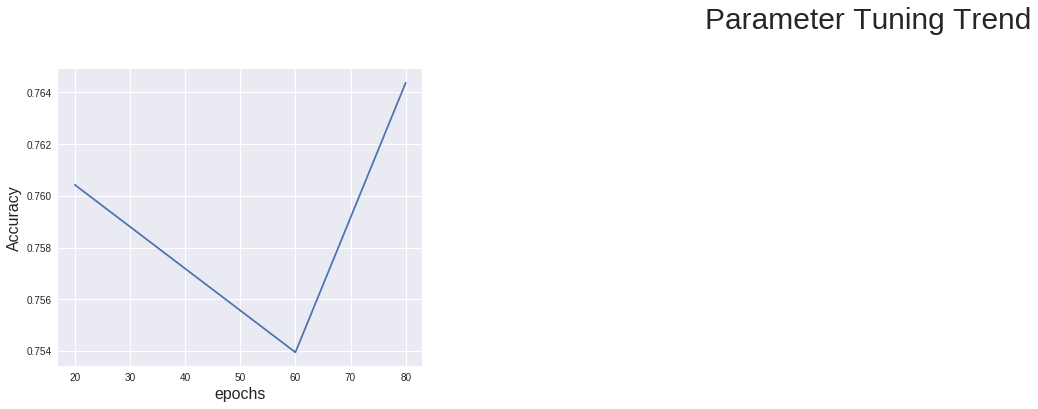

In [35]:
# We'll keep the same params and tune epochs
epochs = [20, 60, 80] 

tuning_options = get_tuning_options(epochs=epochs)

results = run_test(X=X, y=y, 
                   param_dict=param_dict, 
                   tuning_options=tuning_options)

df = wrangle_results(results)
visualize_trend(df)

Here, we got the same result as before, i.e. 80 epochs is the best choice. So, let's update the param_dict:

In [0]:
epochs = get_best_options(df)
param_dict['epochs'] = epochs[0][1]

Next, let's test whether standardizing the data is helpful. We'll first try with the baseline parameters.

In [49]:
param_dict_defaults = get_defaults()
run_test(X=X, y=y, param_dict=param_dict_defaults)

Building model using param_dict:
 {'input_dim': 8, 'num_layers': 2, 'num_units': 8, 'activation': 'relu', 'activation_out': 'sigmoid', 'loss': 'binary_crossentropy', 'initializer': 'random_uniform', 'optimizer': 'adam', 'learning_rate': 0.001, 'metrics': ['accuracy'], 'epochs': 10, 'batch_size': 4, 'one_hot': False}
Starting 10-fold cross-validation...
Finished cross-valiation. Took 1.6 mintues.
Mean Accuracy: 77.47%, Standard Deviation: 3.62%


0.7746924147895974

Wow, incredible! That's 77.47% vs. 74.86%, an almost 4 percentage points increase without doing any tuning! Let's now use the best param options and the standardized data to train a final model.

In [47]:
param_dict = {'input_dim': 8, 'num_layers': 2, 'num_units': 8, 
              'activation': 'relu', 'activation_out': 'sigmoid', 
              'loss': 'binary_crossentropy', 'initializer': 'random_uniform', 
              'optimizer': 'adam', 'learning_rate': 0.0011589780553470678, 
              'epochs': 80, 'batch_size': 2}

run_test(X=X_std, y=y, param_dict=param_dict)

Building model using param_dict:
 {'input_dim': 8, 'num_layers': 2, 'num_units': 8, 'activation': 'relu', 'activation_out': 'sigmoid', 'loss': 'binary_crossentropy', 'initializer': 'random_uniform', 'optimizer': 'adam', 'learning_rate': 0.0011589780553470678, 'epochs': 80, 'batch_size': 2}
Starting 10-fold cross-validation...
Finished cross-valiation. Took 24.1 mintues.
Mean Accuracy: 77.73%, Standard Deviation: 2.39%


0.7773069055660571

There we go! We have the [state-of-the-art accuracy result](https://www.kaggle.com/general/19387) now with 10-fold cross-validation! Although it seems parameter tuning's contribution in performance increase is marginal compared with data standardization.